In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch

os.chdir('..')
from models.architectures.encoders.fc import HFCEncoder
from models.architectures.decoders.fc import HFCDecoder
from models.pt_vae import HFVAE
from multiprocessing import cpu_count
from trainer import VAETrainer
import json
import numpy as np
from utils.nn_utils import  set_seed

print(os.getcwd())
# model parameters

SEED = 50
set_seed(SEED)
INPUT_DIM = 2000
HIDDEN_DIM = 500
LATENT_DIM = 50
NUM_GROUPS = 2

# training parameters
BATCH_SIZE = 500
NUM_EPOCHS = 1000
LEARNING_RATE = 5e-5
CUDA = torch.cuda.is_available()
# beta template for hfvae (gammma, 1, alpha, beta, 0)
alpha = 0.0
beta = 7.0
gamma = 4.0
BETA = (gamma, 1.0, alpha, beta, 0.0)
parameters = {'SEED':SEED, 'INPUT_DIM':INPUT_DIM, 'HIDDEN_DIM':HIDDEN_DIM, 'LATENT_DIM':LATENT_DIM, 'NUM_GROUPS':NUM_GROUPS,
              'BATCH_SIZE':BATCH_SIZE, 'NUM_EPOCHS':NUM_EPOCHS, 'LEARNING_RATE':LEARNING_RATE, 'BETA':BETA}
DATA_PATH = 'resources/datasets/20news/'
SAVE_PATH = 'results/hfvae/a_0/'



/home/dorian/FER/master_thesis/src/base


### Data loading

In [2]:
# data loading
kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if CUDA else {'num_workers': cpu_count()}
labels = json.load(open(DATA_PATH+'topics.json', 'r'))
train_data = np.load(DATA_PATH+'train.npy')
train_labels = np.load(DATA_PATH+'train.labels.npy')
test_data = np.load(DATA_PATH+'test.npy')
test_labels = np.load(DATA_PATH+'test.labels.npy')


train_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(train_data, train_labels)],
                                         batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(test_data, train_labels)],
                                        batch_size=BATCH_SIZE, shuffle=True, **kwargs)



### Model training

In [1]:
# model training
from utils.file_handling import MultiOutput
import sys
f = open(SAVE_PATH+'train_output.txt','w')
original = sys.stdout
# write to output and save output to file
sys.stdout = MultiOutput(sys.stdout, f)

enc = HFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, num_groups=NUM_GROUPS)
dec = HFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE, num_groups=NUM_GROUPS)
model = HFVAE(encoder=enc, decoder=dec, beta=BETA)
model.cuda().double()
optimizer =  torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if CUDA else "cpu")

VAETrainer(model, device, train_loader, test_loader, save_model_path=SAVE_PATH, probtorch=True, included_labels=True).run(optimizer, NUM_EPOCHS)
# save parameters
json.dump(parameters, open(SAVE_PATH+'parameters.json', 'w'))
# return output to normal
sys.stdout = original
f.close()



NameError: name 'SAVE_PATH' is not defined

### Restore model

In [4]:
# EVALUATION
# model loading
parameters = json.load(open(SAVE_PATH+'parameters.json','r'))
enc = HFCEncoder(input_dim=parameters['INPUT_DIM'], hidden_dim=parameters['HIDDEN_DIM'], latent_dim=parameters['LATENT_DIM'], num_groups=parameters['NUM_GROUPS'])
dec = HFCDecoder(latent_dim=parameters['LATENT_DIM'], output_dim=parameters['INPUT_DIM'], batch_size=parameters['BATCH_SIZE'], num_groups=parameters['NUM_GROUPS'])
model = HFVAE(encoder=enc, decoder=dec, beta=parameters['BETA'])
model.load_state_dict(torch.load(SAVE_PATH+'model.pt'))
model.cuda().double()
model.eval()


HFVAE(
  (encoder): HFCEncoder(
    (main): Sequential(
      (0): Linear(in_features=2000, out_features=500, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=500, out_features=50, bias=True)
    (logvar): Linear(in_features=500, out_features=50, bias=True)
  )
  (decoder): HFCDecoder(
    (main): Sequential(
      (0): Linear(in_features=50, out_features=2000, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

### Evaluation
#### t-SNE

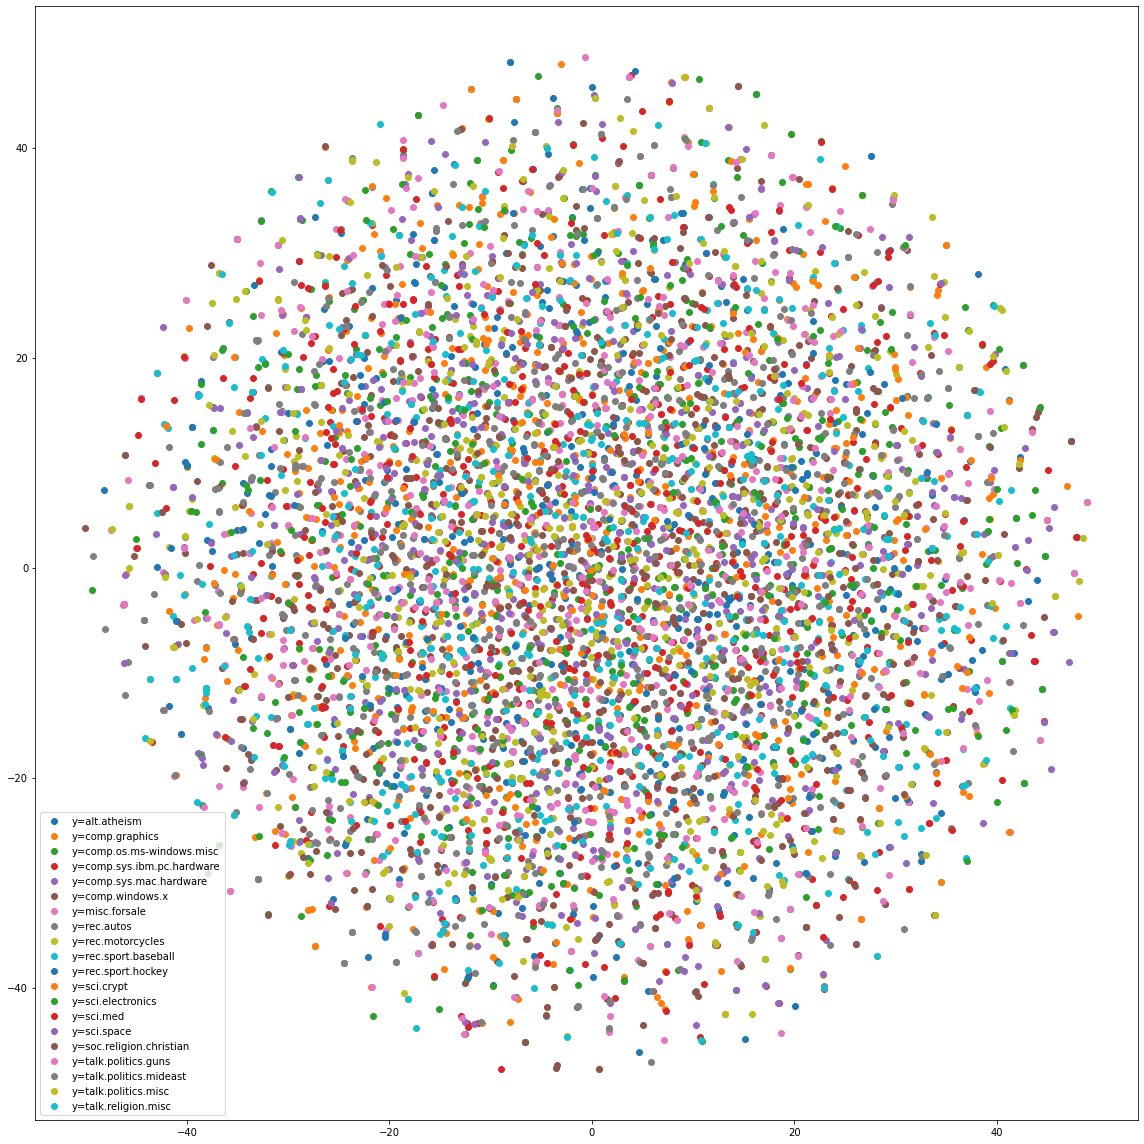

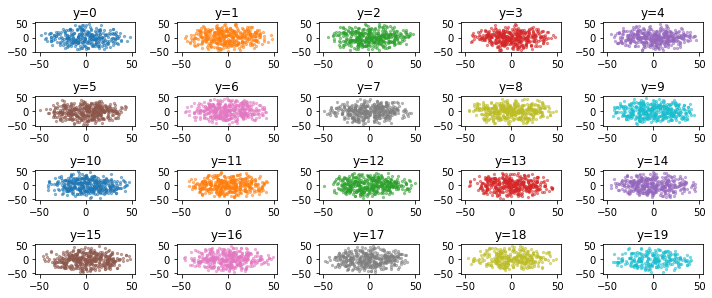

In [6]:
# Embedding visualization
# t-sne
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
zs = []
xs = []
ys = []

for (x, y) in test_loader:
    if len(x) == BATCH_SIZE:
        q = model.encoder(x.cuda().double())
        z_groups = []
        for i in range(NUM_GROUPS):
            z = q['z_'+str(i)].value.cpu().detach().numpy()
            z_groups.append(z)
        z = np.concatenate(z_groups, axis=-1)
        zs.append(z.reshape(-1, LATENT_DIM))
        xs.append(x.numpy())
        ys.append(y.numpy())

zs = np.concatenate(zs, 0)
xs = np.concatenate(xs, 0)
ys = np.concatenate(ys, 0)
zs_mean = zs.mean(0)
zs_std = zs.std(0)

%matplotlib inline
zs2 = TSNE().fit_transform(zs)

fig = plt.figure(figsize=(16,16))
ax = plt.gca()

colors = []
for k in range(len(labels)):
    m = (ys==k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%s'%labels[k])
    colors.append(p.get_facecolor())
ax.legend()
fig.tight_layout()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
# save figure
plt.savefig(SAVE_PATH+'tsne.png')


# for each class independently
fig = plt.figure(figsize=(10,4.25))

for k in range(len(labels)):
    ax = plt.subplot(4,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()
plt.savefig(SAVE_PATH+'tsne_by_class.png')



#### Correlation plot (z)

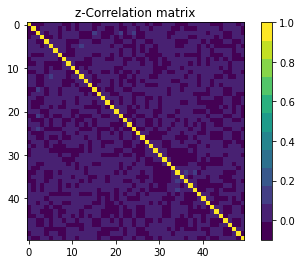

In [7]:
#correlation plot
from matplotlib import cm
cov_matrix = np.corrcoef(zs.T)
plt.imshow(cov_matrix, interpolation='None', cmap=cm.get_cmap('viridis',12))
plt.title('z-Correlation matrix')
plt.colorbar()
# plt.savefig(SAVE_PATH+'z-correlations.png')
# ok - correlations within a group(top left, bottom right)
# no correlations between groups (top right, bottom left)


#### Top words

In [8]:
from evaluation.topics import print_top_words
from utils.file_handling import MultiOutput
# save output
f = open(SAVE_PATH+'topics.txt','w')
original = sys.stdout
sys.stdout = MultiOutput(sys.stdout, f)
# Top words in topics
# load the vocab
vocab = json.load(open(DATA_PATH+'vocab.json','r'))
idx2word = {i:vocab[i] for i in range(len(vocab))}
# get weights of the decoder
emb = model.decoder.main[0].weight.cpu().detach().numpy().T
print_top_words(emb, idx2word)
sys.stdout = original
f.close()



--------------- Topics ------------------
shuttle relative keith fuel engine ken nasa backup select turbo
yeah roger crypto sale rangers games chips criminals keith mike
citizens surrender government drugs banks killed anti human americans state
max deleted koresh die yeah year hell food jesus fire
running mac problem directory convert machine run window good graphics
period telephone national annual greek los april constitution turkish officials
pages motif copies max resource map widget committee postscript served
button disks objects screen unit storage location hole font postscript
israeli status news school mary international arab kids education islamic
people public message response part law fact simply called things
sexual evidence homosexuality patients stats report directory impact homosexual occurs
detroit toronto adams bible lord universe won god wings max
van boards israeli game arab max current pub included period
chips max keys chip key clock escrow serial bits memory
ema

#### NPMI

In [9]:
from evaluation.topics import npmi_coherence_score
import pickle
X_raw = json.load(open(DATA_PATH+'X_raw.json','r'))
decoder_weight = model.decoder.main[0].weight.detach().cpu()
top_words = 10
topics = [
    [idx2word[item.item()] for item in topic]
    for topic in decoder_weight.topk(10, dim=0)[1].t()
]
word_frequencies = pickle.load(open(DATA_PATH+'word_frequencies.pkl','rb'))
joint_word_frequencies = pickle.load(open(DATA_PATH+'jointword_frequencies.pkl','rb'))
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))
print('Max: %f'%max(npmi_per_topic))
print('Topic : %s'%(' '.join(topics[np.argmax(npmi_per_topic)])))
# save results
json.dump({'npmi_per_topic':npmi_per_topic, 'avg_npmi':sum(npmi_per_topic)/len(npmi_per_topic)},open(SAVE_PATH+'npmi.json','w'))



[0.12408769094700815, 0.001542826094347833, 0.24989475683197593, 0.034888246484313, 0.22655303205367058, 0.3079291698541392, 0.23617018351147437, 0.28660380327955226, 0.11840884460704443, 0.2529434855993975, 0.11941502895546609, 0.015469258480672925, 0.06431677117720302, 0.25883276433814234, 0.25797226751474434, 0.2733648200236543, 0.1465985427063802, 0.31006074940290207, 0.2511558301187272, 0.19251090631697407, 0.1490007351393244, 0.21582686263767148, 0.14064067875916117, 0.18254169595022351, 0.15497042161844743, 0.3503955309549332, 0.10081653779860404, -0.14753192328966616, 0.0954247969710346, 0.22704447249737877, 0.26502555768752933, 0.24206016386596418, 0.20940849834492217, 0.029133094893243738, 0.3070761852709073, -0.20259411100479915, 0.4557871728848608, 0.14439441957111548, 0.2703048379492405, 0.22649038150708012, 0.28241650948904723, 0.18715140576307268, 0.13501170096245158, -0.0016524279170703673, 0.18606150668571877, 0.08779203595566429, 0.13447324990766243, 0.174733020358883

In [14]:
# get npmi's for most correlated topics - 4
top_correlations = 4
inds = np.dstack(np.unravel_index(np.argsort(cov_matrix.ravel()), (LATENT_DIM, LATENT_DIM)))[0]
inds = inds[-LATENT_DIM-top_correlations:-LATENT_DIM,:]
print('Inds : ')
print(inds)
covs = [cov_matrix[tuple(ind)] for ind in inds]
print('Covs : ')
print(covs)
cor_topics = set(inds.flatten())
for topic in cor_topics:
    print('%f %s'%(npmi_per_topic[topic], topics[topic]))



Inds : 
[[34 38]
 [38 34]
 [36 34]
 [34 36]]
Covs : 
[0.09704640475367496, 0.09704640475367497, 0.10421710142893945, 0.10421710142893945]
0.307076 ['create', 'religion', 'faith', 'christianity', 'evil', 'god', 'muslim', 'muslims', 'creation', 'gods']
0.455787 ['church', 'christians', 'christ', 'christian', 'jesus', 'catholic', 'bible', 'acts', 'teaching', 'beliefs']
0.270305 ['evidence', 'files', 'pages', 'information', 'serdar', 'form', 'court', 'argic', 'names', 'armenian']


#### LDA for comparison

In [18]:
import gensim
# training classic LDA just for comparison
corpus = gensim.matutils.Dense2Corpus(train_data, documents_columns=False)
lda = gensim.models.LdaMulticore(corpus=corpus,
                                 id2word=idx2word,
                                 num_topics=50,
                                 random_state=100,
                                 passes=10)

In [19]:
coherence_model = gensim.models.CoherenceModel(model=lda,
                                               texts=X_raw,
                                               dictionary=gensim.corpora.dictionary.Dictionary.from_corpus(corpus, idx2word),
                                               coherence='c_npmi')
topic_coherences = coherence_model.get_coherence_per_topic()
print(topic_coherences)
print(sum(topic_coherences)/len(topic_coherences))

[0.05049653446593177, 0.018853839167305892, 0.13889612641516624, 0.022945950029298473, -0.0006003120676231906, 0.1428051110383231, 0.11315420450649968, 0.0603837412866034, -0.07631427244884832, 0.13477647813050067, -0.12113910056456596, 0.03452064847060468, -0.012526820374331515, 0.13433586922156424, 0.08481460233152115, -0.0046095948153488525, 0.14795521458271274, 0.0643200487789307, 0.09741848749268073, -0.028582443389426147, 0.013560249247074262, -0.029854817229828124, 0.17069680278113172, 0.041594051846695755, 0.023262740152461197, -0.015284992085027458, 0.02957366350989352, -0.012382081119426134, -0.0809209396639903, -0.05902062671151506, -0.03754023400933772, 0.054073430455275046, 0.044970844029611955, 0.004594873432606471, 0.11843654659168892, 0.05827839243050851, -0.12443164045021132, 0.018179347383259856, -0.06328050309834121, 0.003220650621897766, 0.018718541240538306, -0.009209533430282583, 0.09513379877887652, 0.16329721392069838, 0.024118672311393214, -0.06975283708929722,

In [21]:
# with my implementation
topics = lda.show_topics(num_topics=50, num_words=10, formatted=False)
topics = [[t[0] for t in topic[1]] for topic in topics]
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))
for topic in topics:
    print(topic)



[0.16410033369830448, 0.3111506547532112, 0.3114129065896065, 0.2532044613857142, 0.18540062448569977, 0.3571823886854365, 0.3122368409907439, 0.2697089955510378, 0.14553792552260353, 0.416451331905533, 0.19892567161221894, 0.27745537742764353, 0.20559272753652633, 0.340324700723863, 0.4240882933319373, 0.22213953829759964, 0.4676971884705831, 0.13982192371931396, 0.3665607427566965, 0.18697436442110582, 0.32289840459720787, 0.24979912838610635, 0.3740518835592937, 0.21790243274365118, 0.21180207632988513, 0.20816621490125248, 0.18736735069409186, 0.17593497473809364, 0.17990350537115046, 0.18011868130999345, 0.23890330528870785, 0.237629458728827, 0.16311259013485555, 0.16870227815922761, 0.3344769660198739, 0.23457751758471912, 0.15180438273571348, 0.17458782640347076, 0.1379065730339304, 0.28150057621561597, 0.1909182071256871, 0.28186802094285945, 0.26290095125736423, 0.4331352499031874, 0.15669152368152559, 0.14540524721734785, 0.18392229075549102, 0.14442045864007083, 0.121592459

#### Mutual informtaion - I(x,zd)

In [ ]:
# mutual information
from evaluation.NPEET.npeet import entropy_estimators as ee
import warnings
warnings.filterwarnings("ignore")
# i don't know if this is right but it works
# mi = ee.mi(xs, zs)
# this one also works
mis = []
for i in range(1):
    mi = ee.mi(zs[:, i].reshape(-1, 1), xs)
    print(mi)
    mis.append(mi)
print(mis)
# mis = [ee.mi(zs[:, i].reshape(-1, 1), xs) for i in range (zs.shape[1])]
# print(sorted(mis))



#### Mutual information - I(yk,zd)